# Model Evaluation

This notebook covers methods for evaluating machine learning models. 

## Imports

Imports all of the libraries for the notebook

In [2]:
%matplotlib inline
from math import ceil
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import graphviz

from sklearn.datasets import load_boston, load_iris, load_wine
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, validation_curve, learning_curve 
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

import seaborn as sns

## Load in the data

This pulls in the Boston house price, wine, and iris datasets that have bene used in other notebooks for regression and classification.

In [3]:
data_wine = load_wine()
print("Feature names:", data_wine.feature_names)
print("Target names:", data_wine.target_names)
print("Shape:", data_wine.data.shape)
print("")

data_iris = load_iris()
print("Feature names:", data_iris.feature_names)
print("Target names:", data_iris.target_names)
print("Shape:", data_iris.data.shape)
print("")

data_boston = load_boston()
# print(data_boston.DESCR)
print("Shape:", data_boston.data.shape)


Feature names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Target names: ['class_0' 'class_1' 'class_2']
Shape: (178, 13)

Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']
Shape: (150, 4)

Shape: (506, 13)


## Validation Curves

Validation curves are used to visualize the impact of changing a single hyper-parameter on training and testing error.

Typically, you'd expect that increasing a hyper-parameter makes the model more or less complex (i.e. increasing minimum number of samples in a leaf of a decision tree makes the model less complex. Increasing the depth of the tree makes the model more complex.) A validation curve can help visually identify an optimal setting for a parameter i.e. where test error is minimized.

In [63]:
def Plot_Validation_Curves(X, y, model, param_name, param_range, scoring):
    train_scores, test_scores = validation_curve(
        model, X, y, param_name=param_name, param_range=param_range,
        cv=10, scoring=scoring, n_jobs=4)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

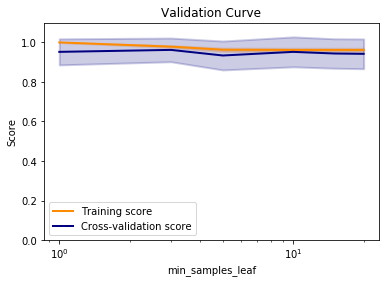

In [64]:
X_train, X_test, y_train, y_test = train_test_split(data_iris.data, data_iris.target, test_size=0.30, random_state = 0)

min_samples_leaf = [1, 3, 5, 10, 15, 20]
Plot_Validation_Curves(X_train, y_train, DecisionTreeClassifier(), 'min_samples_leaf', min_samples_leaf, 'accuracy')

## Learning Curves

Learning curves help visualize impact of increasing the amount of training data available to a particular model. Plotting versions for different combinations of hyper-parameters 

In [52]:
def Plot_Learning_Curves(X, y, models, model_names, scoring):  
    # Create 10 cross-validation sets for training and testing sets
    cv = ShuffleSplit(n_splits=10, test_size = 0.20, random_state = 0)
    
    # Generate the 10 different training set sizes
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 10)).astype(int)
    
    # Create the figure window
    fig = plt.figure(figsize=(10,7))

    # Create four different models based on degree (deg)
    for i in range(len(models)):
        # Calculate the training and testing scores
        sizes, train_scores, test_scores = learning_curve(models[i], X, y, \
            cv=cv, train_sizes=train_sizes, scoring=scoring, n_jobs=4)
        
        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis=1)
        train_mean = np.mean(train_scores, axis=1)
        test_std = np.std(test_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)

        # Subplot the learning curve 
        ax = fig.add_subplot(2, 2, i+1)
        ax.plot(sizes, train_mean, 'o-', color='r', label='Training Score')
        ax.plot(sizes, test_mean, 'o-', color='g', label='Testing Score')
        ax.fill_between(sizes, train_mean-train_std, train_mean+train_std, alpha=0.15, color='r')
        ax.fill_between(sizes, test_mean-test_std, test_mean+test_std, alpha=0.15, color='g')
        
        # Labels
        ax.set_title('%s'%(model_names[i]))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    # ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad=0.)
    ax.legend()
    fig.suptitle('Learning Curves', fontsize=16, y=1.03)
    fig.tight_layout()
    plt.show()


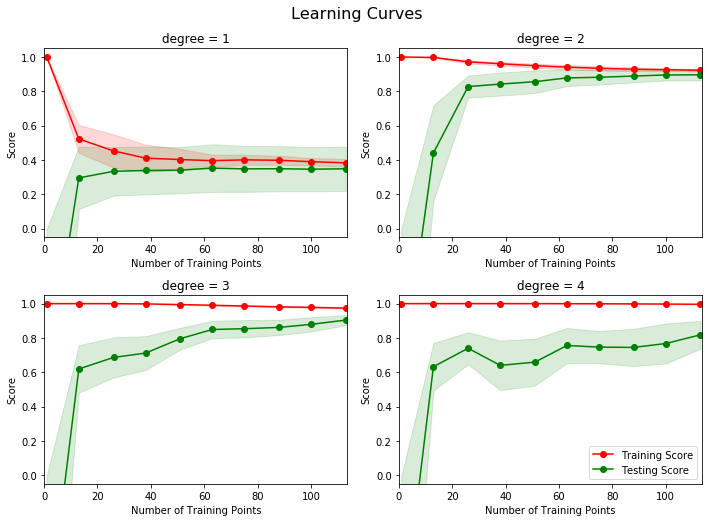

In [53]:
features_transformed = pd.DataFrame(data=data_boston.data, columns=data_boston.feature_names)

# Applying scaling using MinMaxScaler to the log transformed data set and storing it in a new data frame called 'features_log_minmax_transform'
scaler = MinMaxScaler()
features_transformed[data_boston.feature_names] = scaler.fit_transform(features_transformed)
X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(features_transformed, 
                    data_boston.target, test_size = 0.2, random_state = 0)

def PolynomialRegression(degree=2, linear_model=LinearRegression, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), linear_model(**kwargs))

degrees = [1, 2, 3, 4]
models = [PolynomialRegression(degree=k, linear_model=Lasso) for k in degrees]
model_names = ["degree = %d"%k for k in degrees]

Plot_Learning_Curves(X_train, y_train, models, model_names, 'r2')

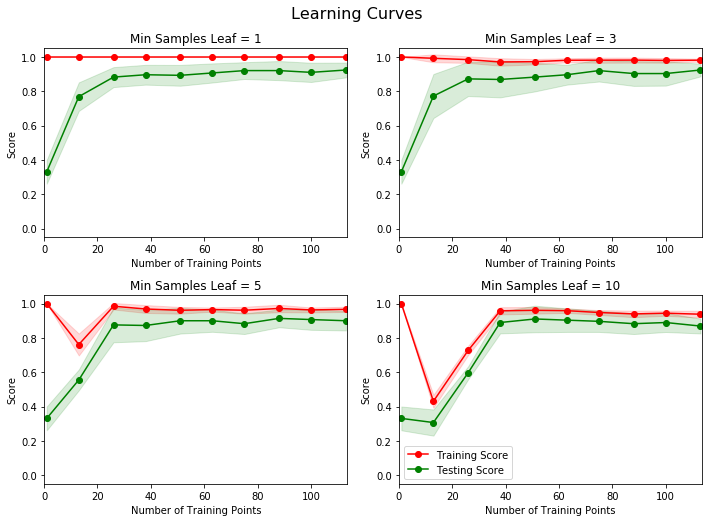

In [54]:
X_train, X_test, y_train, y_test = train_test_split(data_wine.data, data_wine.target, test_size=0.20, random_state = 0)

min_samples_leaf = [1, 3, 5, 10]
models=[DecisionTreeClassifier(min_samples_leaf=k) for k in min_samples_leaf]
model_names = ["Min Samples Leaf = %d"%k for k in min_samples_leaf]

Plot_Learning_Curves(X_train, y_train, models, model_names, 'accuracy')

In [57]:
X_train, X_test, y_train, y_test = train_test_split(data_wine.data, data_wine.target, test_size=0.20, random_state = 0)

dt = DecisionTreeClassifier()
parameters = {'criterion': ('gini', 'entropy'), 'min_samples_leaf':[1, 3, 5]}
clf = GridSearchCV(dt, parameters, cv=5, return_train_score=True)
clf.fit(X_train, y_train)
cv_results = pd.DataFrame(clf.cv_results_)
print(cv_results[['params', 'mean_fit_time', 'mean_score_time', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False))
best_estimator = clf.best_estimator_

print("Training confusion:")
y_train_pred = best_estimator.predict(X_train)
print(confusion_matrix(y_train, y_train_pred))

print("Test confusion:")
y_test_pred = best_estimator.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))

                                            params  mean_fit_time  \
0     {'criterion': 'gini', 'min_samples_leaf': 1}       0.000986   
2     {'criterion': 'gini', 'min_samples_leaf': 5}       0.001338   
1     {'criterion': 'gini', 'min_samples_leaf': 3}       0.001388   
3  {'criterion': 'entropy', 'min_samples_leaf': 1}       0.002564   
4  {'criterion': 'entropy', 'min_samples_leaf': 3}       0.001948   
5  {'criterion': 'entropy', 'min_samples_leaf': 5}       0.001190   

   mean_score_time  mean_test_score  
0         0.000637         0.936620  
2         0.000391         0.922535  
1         0.000500         0.915493  
3         0.000981         0.915493  
4         0.000595         0.915493  
5         0.000595         0.901408  
Training confusion:
[[45  0  0]
 [ 0 55  0]
 [ 0  0 42]]
Test confusion:
[[14  0  0]
 [ 1 15  0]
 [ 0  0  6]]


In [76]:
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

C:\Users\CobyLU\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


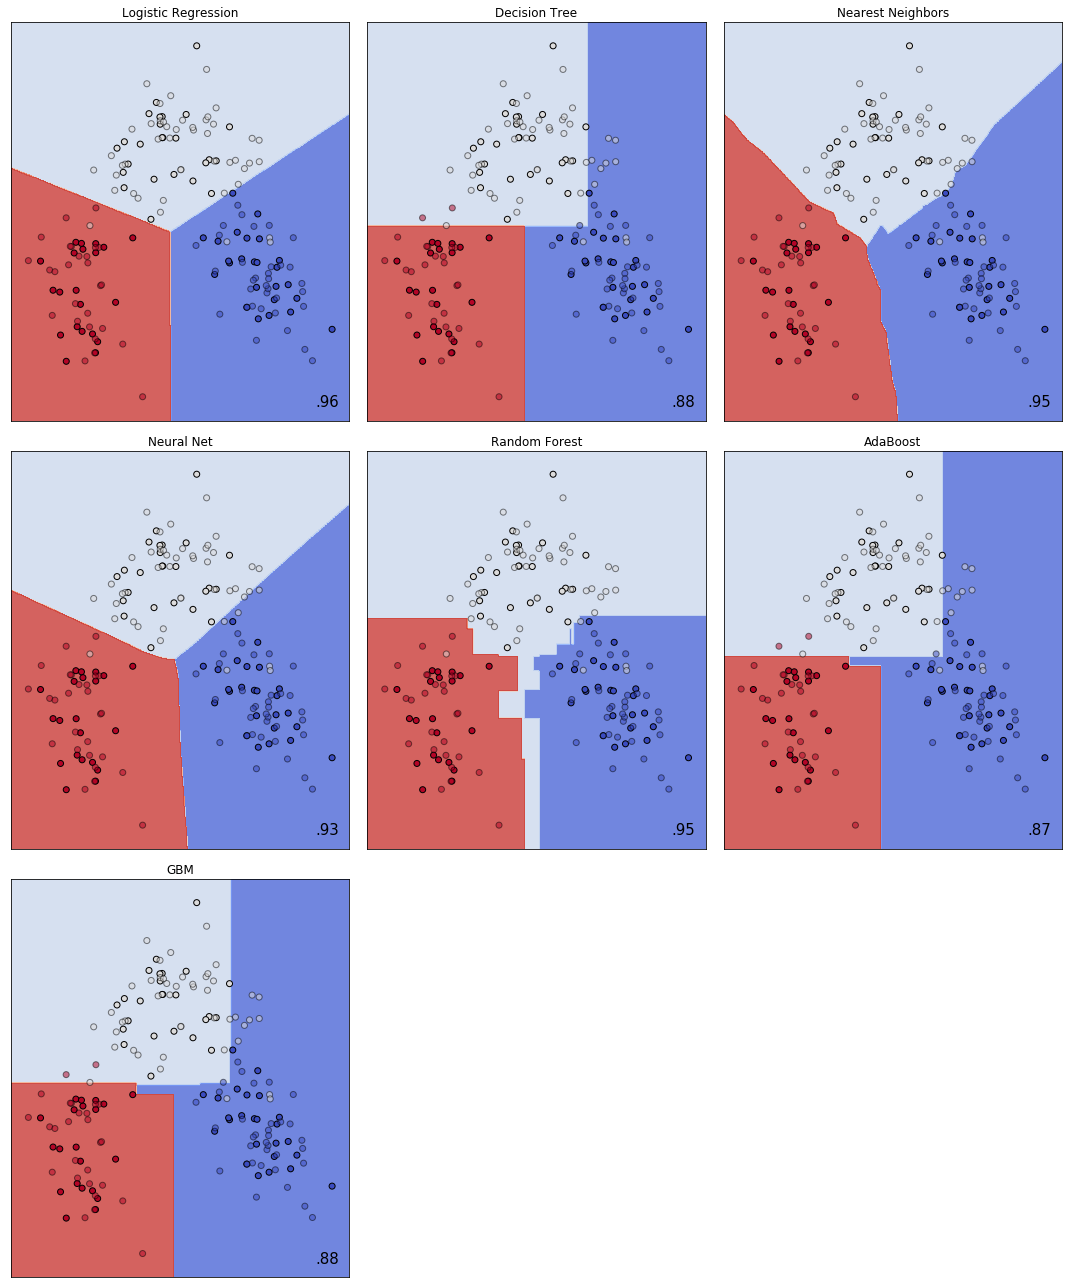

In [82]:
X_scale = StandardScaler().fit_transform(data_wine.data)
X_pca = pca.fit_transform(X_scale)
X_train, X_test, y_train, y_test = train_test_split(X_pca, data_wine.target, test_size=0.60, random_state = 0)

h = .02  # step size in the mesh

names = ["Logistic Regression", "Decision Tree", "Nearest Neighbors", 
         "Neural Net", "Random Forest", "AdaBoost", "GBM"]

classifiers = [
    LogisticRegression(fit_intercept=True, penalty='l1'),
    DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1),
    KNeighborsClassifier(3, weights='uniform'),
    MLPClassifier(hidden_layer_sizes=(100), learning_rate_init=.0005),    
    RandomForestClassifier(max_depth=5, n_estimators=10, min_samples_leaf=1),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=10), n_estimators=50),
    GradientBoostingClassifier(min_samples_leaf=20, n_estimators=100)]

figure = plt.figure(figsize=(15, 18))

x_min, x_max = X_pca[:, 0].min() - .5, X_pca[:, 0].max() + .5
y_min, y_max = X_pca[:, 1].min() - .5, X_pca[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

i = 1
for name, clf in zip(names, classifiers):
    
    ax = plt.subplot(3, 3, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. 
    plot_contours(ax, clf, xx, yy,cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm,
               edgecolors='k', alpha=0.5)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)

    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i += 1

plt.tight_layout()
plt.show()